# Install necessary libraries

In [172]:
# INSTALL numpy. COMMENT THIS IF numpy IS ALREADY INSTALLED.
# %pip install numpy

In [173]:
# INSTALL tensorflow. COMMENT THIS IF tensorflow IS ALREADY INSTALLED.
# %pip install tensorflow

In [174]:
# INSTALL tensorflow_hub. COMMENT THIS IF tensorflow_hub IS ALREADY INSTALLED.
# %pip install tensorflow_hub

In [175]:
# INSTALL tqdm. COMMENT THIS IF tqdm IS ALREADY INSTALLED.
# %pip install tqdm

In [176]:
# INSTALL torchvision. COMMENT THIS IF torchvision IS ALREADY INSTALLED.
# %pip install torchvision

In [177]:
# INSTALL ipynb. COMMENT THIS IF ipynb IS ALREADY INSTALLED
# %pip install ipynb

In [178]:
# INSTALL ipynb. COMMENT THIS IF ipynb IS ALREADY INSTALLED
# %pip install keras

In [179]:
# IF YOU WANT TO CHECK ALL PACKAGES ARE INSTALLED SUCCESSFULLY.
# UNCOMMENT THE FOLLOWING LINE AND CHECK FOR INSTALLED PACKAGES.
# %pip list

In [180]:
# INSTALL matplotlib. COMMENT THIS IF ipynb IS ALREADY INSTALLED
# %pip install matplotlib

# Import necessary libraries

In [181]:
import numpy as np
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"                                     # IGNORE THE WARNINGS FROM IMPORTING TENSERFLOW.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub                                                 # USING TENSORFLOW_HUB WE WILL HAVE A PRETRAINED EFFICIENT MODEL THAT WE WILL BE USING.
from tqdm import tqdm                                                        # JUST FOR GETTING A PROGRESS BAR FOR THE CURRENT EPOCH.                                                
from ipynb.fs.full.dataset import get_loaders                                # we need to import dataset.ipynb notebook.
import matplotlib.pyplot as plt                                              # IMPORT matplotlib to create graphs.

# Setting variables and environment (using EfficientNetB0 with 10 Epochs)

In [182]:
physical_devices = tf.config.list_physical_devices( "GPU" )                  # SETTING THE PHYSICAL DEVICES.
if len( physical_devices ) > 0:                                              # MIGHT NOT NECESSARY, BUT ITS SAFE PRECAUSION TO TAKE.
    tf.config.experimental.set_memory_growth( physical_devices[0], True)

URL = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"        # URL TO TENSORFLOW HUB WHERE DOWNLOAD THE FEATURE VECTOR ASSOCIATE TO AN EFFICIENTNET MODEL.
                                                                             # HERE WE ARE GOING TO USE THE SMALLEST EFFICIENTNET MODEL JUST TO MAKE IT BIT FASTER TO TRAIN.
                                                                             # THAT IS EFFICIENTNET B0 MODEL.
IMG_SIZE = 224                                                               # IMAGE SIZE DEPEND ON THE MODEL. IF INCREASE b0 TO b1, YOU NEED TO CHANGE THE IMAGE SIZE TO 240.
BATCH_SIZE = 32
NUM_CLASSES = 133
NUM_EPOCHS = 10
DATA_DIR = "data/"
MODEL_PATH = "efficientnetb0/"                                               # SETTING WHERE WE WANT TO SAVE THE MODEL.
LOAD_MODEL = False

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "1"
os.environ["TFHUB_CACHE_DIR"] = "E:/SDGP_TROJANS/machine_learning_component/efficientNet_b0_accuracy-80.5-700mbdata/TFHUB_CACHE"    # WHERE TO SAVE THE CACHE FILES WHILE BUILDING MODEL.

# Setting sequential model and building model

In [183]:
def get_model( url, img_size, num_classes):
    model = tf.keras.Sequential([
        hub.KerasLayer( url, trainable = True ),
        layers.Dense( 1000, activation = "relu" ),
        layers.Dropout( 0.3 ),
        layers.Dense( num_classes, activation = "softmax" ),
    ])

    model.build( [None, img_size, img_size, 3] )                              # BUILDING THE MODEL. None FOR THE BATCH. 3 IS NUMBER OF CHANNELS.
    return model

In [184]:
@tf.function                                                                  # WRAPPING WITH tf.function FOR SOME ADDITIONAL OPTIMIZATION.
def train_step( data, labels, acc_metric, model, loss_fn, optimizer ):
    
    with tf.GradientTape() as tape:
        predictions = model( data, training = True )
        loss = loss_fn( labels, predictions )

    gradients = tape.gradient( loss, model.trainable_weights )
    optimizer.apply_gradients( zip( gradients, model.trainable_weights ) )
    acc_metric.update_state( labels, predictions )                             # AT LAST UPDATING THE ACCURACY METRIC, WHICH WILL BE SORT OF RUNNING ACCURACY ACROSS THE EPOCHS.

# Model evaluation

In [185]:
def evaluate_model( ds_validation, model ):
    accuracy_metric =  keras.metrics.SparseCategoricalAccuracy()               # HAVING accuracy_metric TO KEEP TRACK OF WHAT IS THE ACCURACY ACROSS THE VALIDATION SET.

    for idx, ( data, labels) in enumerate( ds_validation ):
        # CONVET THE DATA TO HAVE THE CORRECT DIMENSIONS.
        data = data.permute( 0, 2, 3, 1 )                
        data = tf.convert_to_tensor( np.array( data ) )
        labels = tf.convert_to_tensor( np.array( labels ) )

        y_pred = model( data, training = False )
        accuracy_metric.update_state( labels, y_pred )

    accuracy = accuracy_metric.result()
    print( f"Accuracy over validation set: { accuracy }" )
     

# Plotting (training and validation loss) and ( training and validation accuracy)

In [186]:
def plotTheGraphs(train_loss, val_loss, train_acc, val_acc):
    # Plot training and validation loss
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Apply a learning rate scheduler
# Training Loop
# calculate train loss, train accuracy, validation loss, validation accuracy

In [187]:
def main():
    train_loader, dev_loader = get_loaders( DATA_DIR + "train", DATA_DIR + "dev", BATCH_SIZE, IMG_SIZE )  
    
    # SETUP THE TRAINING.
    if LOAD_MODEL:
        print("Loading model")
        model = keras.models.load_model( MODEL_PATH )
    
    # IF WE WANT TO CONTINUE THE TRAINING, WE CAN START THE TRAINING AND RERUNNING IT. OTHERWISE, WE CAN USE THE CREATED get_model() function.
    else:
        print("Building model")
        model = get_model( URL, IMG_SIZE, NUM_CLASSES )

    # SETUP THE OPTIMIZER
    # SPECIFY THE LEARNING RATE(lr) AS 3e-4. 
    # WE ARE NOT ACTUALLY GOING TO PLAYing AROUND TOO MUCH HEAVY LEARNING RATE.
    # YOU CAN USE LEARNING RATE SCHEDULAR, THAT WOULD MOST LIKELY IMPROVE THE MODEL. 

    # USING LEARNING RATE SCHEDULER INSTEAD OF HARDCODING LEARNING RATE AS FOLLOWING COMMENTED LINE (e.g. optimizer = keras.optimizers.Adam( learning_rate = 3e-4 )).
    lr_schedule = keras.optimizers.schedules.ExponentialDecay( initial_learning_rate = 1e-3, decay_steps = 10000, decay_rate = 0.9 )
    optimizer = keras.optimizers.Adam(learning_rate = lr_schedule)

    # optimizer = keras.optimizers.Adam( learning_rate = 3e-4 )

    # CREATING LOSS FUNCTION.
    loss_fn = keras.losses.SparseCategoricalCrossentropy( from_logits = False )
    # THIS IS FOR THE RUNNING ACCURACY.
    acc_metric = keras.metrics.SparseCategoricalAccuracy()


    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    # TRAINING LOOP
    for epoch in range(NUM_EPOCHS):

        epoch_train_loss = []
        epoch_train_accuracy = []

        for idx, ( data, labels ) in enumerate( tqdm(train_loader) ):

            # SINCE WE ARE LOADING DATA IN PyTorch WE NEED TO SWAP THE ACCESS FOR THE NUMBER OF CHANNELS, BECAUSE THESE CHANNELS ARE NOT STRUCTURED IN THE SAMA WAY.
            # PyTorch: N X C X H X W       TensorFlow: N X H X W X C       N -      , H - HEight  , W - WIDTH  ,  C - CHANNELS
            # N IS IN THE SAME POSITION IN BOTH. H HAS 2 INDEX, GET H TO SECOND POSITION.LIKEWISE...

            data = data.permute( 0, 2, 3, 1 )
            data = tf.convert_to_tensor( np.array( data ) )
            labels = tf.convert_to_tensor( np.array( labels ) )

            train_step( data, labels, acc_metric, model, loss_fn, optimizer )

            # CHECKING THE INDEX
            # Saving the model periodically during training is a good practice because it allows you to recover the model if the training process is interrupted or if 
            # you need to continue training later. It also allows you to compare different versions of the model and choose the one that performs best on the development set.
            # Evaluating the model on the development set periodically during training is also important because it allows you to monitor the generalization performance of 
            # the model. The development set is typically used to tune the hyperparameters of the model (e.g., learning rate, batch size, regularization strength), so evaluating 
            # the model on this set can help you make decisions about which hyperparameters to use. It also allows you to detect overfitting, which is when the model is fitting too 
            # closely to the training data and is not generalizing well to new data.
            if idx % 150 == 0 and idx > 0:
                # GET THE TRAINING ACCRACY, PRINT THAT ACCURACY. REMEMBER, THIS IS THE RUNNING TRAINING ACCURACY SO FAR IN THE EPOCHS.
                train_acc =  acc_metric.result()
                print( f"Accuracy over epoch (so far) {train_acc}" )
                
                # evaluation.
                evaluate_model( dev_loader, model )
                model.save( MODEL_PATH + f"Epoch-{epoch}/")  # save each epoch seperately.


            # append loss and accuracy of the current epoch to relevant lists.
            epoch_train_loss.append( loss_fn(labels, model(data)).numpy() )
            epoch_train_accuracy.append( acc_metric.result().numpy() )

        # append the mean values of both epoch_train_loss and epoch_train_accuracy to the
        train_loss.append( np.mean(epoch_train_loss) )
        train_accuracy.append( np.mean(epoch_train_accuracy) )

    
        epoch_val_loss = []
        epoch_val_accuracy = []

        for idx, (data, labels) in enumerate(dev_loader):

            # Swap the access for the number of channels to match TensorFlow
            data = data.permute(0, 2, 3, 1)
            data = tf.convert_to_tensor(np.array(data))
            labels = tf.convert_to_tensor(np.array(labels))

            # Predict on validation data
            epoch_val_loss.append( loss_fn(labels, model(data)).numpy() )
            acc_metric.update_state( labels, model(data) )
            epoch_val_accuracy.append( acc_metric.result().numpy() )


        val_loss.append( np.mean(epoch_val_loss) )
        val_accuracy.append( np.mean(epoch_val_accuracy) )

        # Print epoch summary
        print(  f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss[-1]:.4f}, Train Acc: {epoch_train_accuracy[-1]:.4f}, Val Loss: {epoch_val_loss[-1]:.4f}, Val Acc: {epoch_val_accuracy[-1]:.4f}" )

        # Reset the accuracy metric
        acc_metric.reset_states()

    # plot the graphs
    plotTheGraphs( train_loss, val_loss, train_accuracy, val_accuracy )

getting loaders


100%|██████████████████████████████████████████████████████████████████████████| 6680/6680 [00:00<00:00, 954159.88it/s]

Building model



 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [34:23<14:17, 14.54s/it]

Accuracy over epoch (so far) 0.43315398693084717
Accuracy over validation set: 0.5257484912872314


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-0/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-0/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [50:03<00:00, 14.37s/it]


Epoch 1/10, Train Loss: 0.6975, Train Acc: 0.4892, Val Loss: 0.1227, Val Acc: 0.4970


 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [34:39<14:30, 14.76s/it]

Accuracy over epoch (so far) 0.7119205594062805
Accuracy over validation set: 0.6107784509658813


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-1/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-1/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [51:54<00:00, 14.90s/it]


Epoch 2/10, Train Loss: 0.2173, Train Acc: 0.7196, Val Loss: 0.0056, Val Acc: 0.7151


 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [38:03<14:05, 14.33s/it]

Accuracy over epoch (so far) 0.7595198750495911
Accuracy over validation set: 0.688622772693634


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-2/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-2/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [55:23<00:00, 15.90s/it]


Epoch 3/10, Train Loss: 0.3846, Train Acc: 0.7618, Val Loss: 1.0198, Val Acc: 0.7501


 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [40:48<17:35, 17.89s/it]

Accuracy over epoch (so far) 0.8240894079208374
Accuracy over validation set: 0.688622772693634


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-3/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-3/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [58:40<00:00, 16.84s/it]


Epoch 4/10, Train Loss: 0.5480, Train Acc: 0.8234, Val Loss: 5.7416, Val Acc: 0.7987


 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [33:15<15:07, 15.38s/it]

Accuracy over epoch (so far) 0.8342301249504089
Accuracy over validation set: 0.6742514967918396


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-4/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-4/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [51:24<00:00, 14.76s/it]


Epoch 5/10, Train Loss: 0.2443, Train Acc: 0.8383, Val Loss: 1.0940, Val Acc: 0.8230


 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [34:39<18:48, 19.12s/it]

Accuracy over epoch (so far) 0.8580297827720642
Accuracy over validation set: 0.6718562841415405


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-5/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-5/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [51:36<00:00, 14.82s/it]


Epoch 6/10, Train Loss: 0.1065, Train Acc: 0.8537, Val Loss: 0.7556, Val Acc: 0.8321


 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [35:24<11:52, 12.07s/it]

Accuracy over epoch (so far) 0.8580297827720642
Accuracy over validation set: 0.685029923915863


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-6/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-6/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [48:32<00:00, 13.94s/it]


Epoch 7/10, Train Loss: 0.2416, Train Acc: 0.8627, Val Loss: 0.1054, Val Acc: 0.8459


 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [35:33<13:50, 14.07s/it]

Accuracy over epoch (so far) 0.875
Accuracy over validation set: 0.655089795589447


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-7/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-7/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [51:50<00:00, 14.88s/it]


Epoch 8/10, Train Loss: 0.1870, Train Acc: 0.8753, Val Loss: 1.3183, Val Acc: 0.8551


 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [38:03<13:57, 14.20s/it]

Accuracy over epoch (so far) 0.8830711841583252
Accuracy over validation set: 0.7401197552680969


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-8/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-8/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [53:29<00:00, 15.35s/it]


Epoch 9/10, Train Loss: 0.0262, Train Acc: 0.8882, Val Loss: 1.1967, Val Acc: 0.8681


 72%|█████████████████████████████████████████████████████████▍                      | 150/209 [31:57<14:11, 14.44s/it]

Accuracy over epoch (so far) 0.8884519934654236
Accuracy over validation set: 0.7269461154937744


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-9/assets


INFO:tensorflow:Assets written to: efficientnetb0/Epoch-9/assets
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [46:51<00:00, 13.45s/it]


Epoch 10/10, Train Loss: 0.0334, Train Acc: 0.8918, Val Loss: 1.3726, Val Acc: 0.8703


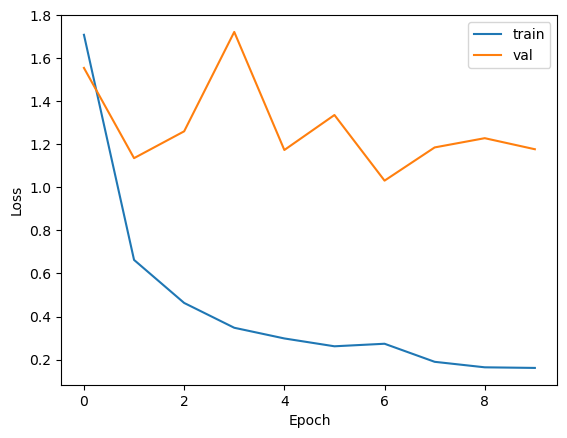

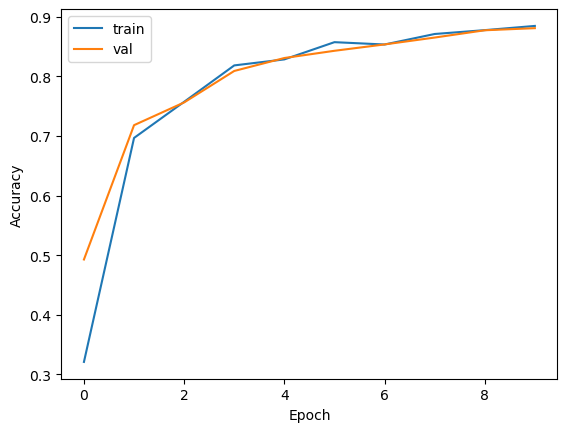

In [188]:
if __name__ == "__main__":
    main()